# Import Library

In [19]:
!pip install yfinance
# Load data
import yfinance as yf
import pandas as pd
import numpy as np
import os
from datetime import datetime
import time

#EDA
from statsmodels.tsa.seasonal import seasonal_decompose

# Data preparation
from sklearn.preprocessing import MinMaxScaler # Import MinMaxScaler

# Modelling
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Inference & save model
import json
from datetime import datetime
import tensorflow as tf
!pip install ta



# Load Data

In [20]:
def get_eurusd_data(start_date='2015-01-01', end_date='2015-06-06', csv_path='eurusd_data.csv', force_download=False, delay=5):
    if end_date is None:
        end_date = datetime.today().strftime('%Y-%m-%d')

    if not force_download and os.path.exists(csv_path):
        print(f"Membaca data dari cache: {csv_path}")
        data = pd.read_csv(csv_path, index_col=0, parse_dates=True)
    else:
        print(f"Mengunduh data EUR/USD dari Yahoo Finance: {start_date} sampai {end_date}")
        time.sleep(delay)
        data = yf.download('EURUSD=X', start=start_date, end=end_date)

        # Ambil hanya 5 kolom yang diinginkan
        columns_to_keep = ['Close', 'High', 'Low', 'Open', 'Volume']
        data = data[columns_to_keep]

        # Ganti nama kolom sesuai urutan (agar mudah pada data preparation)
        data.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

        data.to_csv(csv_path)
        print(f"Data disimpan ke {csv_path}")

    return data

data = get_eurusd_data(end_date=None)  # end_date=None untuk hari ini


Membaca data dari cache: eurusd_data.csv


In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, f1_score
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import json
import ta

# ===== STEP 1: Load Data =====
data = pd.read_csv("eurusd_data.csv", index_col='Date', parse_dates=True)
data = data.sort_index()

# Drop volume jika semua 0 atau sama
if data['Volume'].nunique() == 1 and data['Volume'].iloc[0] == 0:
    data.drop('Volume', axis=1, inplace=True)

#EDA

## Cek missing value

In [22]:
data.isnull().sum()

,0
Close,0
High,0
Low,0
Open,0


## Meneliti 5 data terakhir

In [23]:
data.tail()

,Close,High,Low,Open
Date,,,,
2025-06-04,1.138446,1.143458,1.135938,1.138446
2025-06-05,1.142204,1.149425,1.140615,1.142204
2025-06-06,1.145383,1.145869,1.137230,1.145383
2025-06-09,1.140784,1.144034,1.138758,1.140784
2025-06-10,1.142805,1.144833,1.137462,1.142805


## Meneliti dimensi dataset

In [24]:
print("Dimensi dataset:", data.shape)

Dimensi dataset: (2718, 4)


## Meneliti nilai

In [25]:
data.describe()

,Close,High,Low,Open
count,2718.000000,2718.000000,2718.000000,2718.000000
mean,1.117668,1.121265,1.114036,1.117650
std,0.052347,0.052123,0.052509,0.052339
min,0.959619,0.967006,0.954016,0.959619
25%,1.083412,1.086720,1.080334,1.083456
50%,1.114163,1.117703,1.110640,1.114225
75%,1.150622,1.154154,1.146063,1.150364
max,1.251001,1.255808,1.245051,1.251267


### Insight :    
- Nilai volume 0, karena pasangan USD sering tidak ditampilkan data nya oleh beberapa pihak, salah satunya platform sumber kami yaitu Yahoo Finance.
- Volume dihapus karena tidak memiliki pengaruh pada time series, karena tidak ada datanya.

## Visualisasi Tren Harga

<Axes: title={'center': 'EUR/USD Closing Price'}, xlabel='Date'>

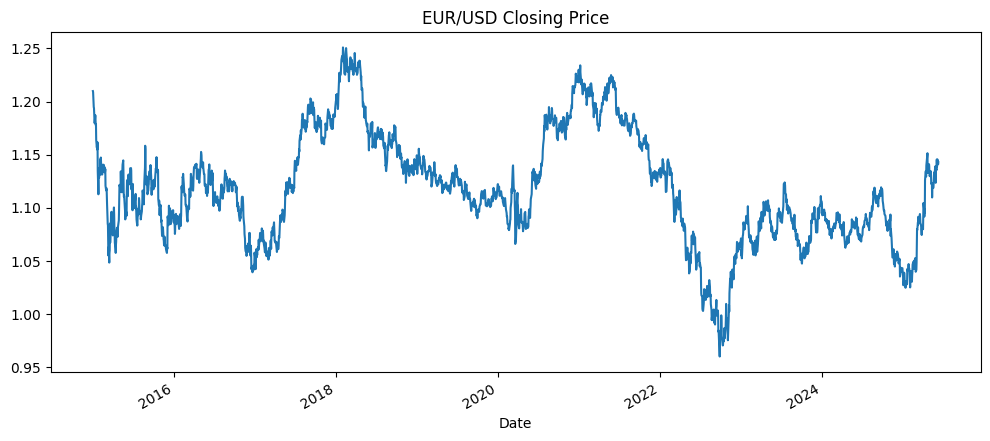

In [26]:
data['Close'].plot(figsize=(12, 5), title='EUR/USD Closing Price')

<Axes: title={'center': 'EUR/USD High Price'}, xlabel='Date'>

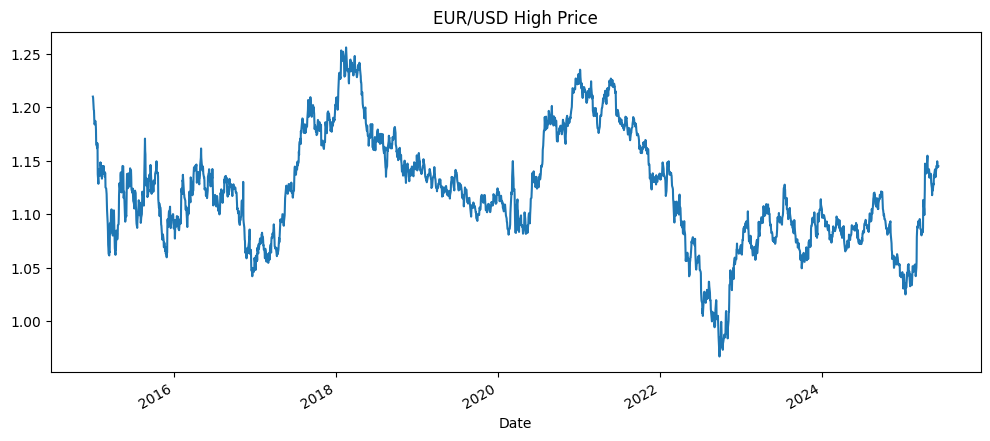

In [27]:
data['High'].plot(figsize=(12, 5), title='EUR/USD High Price')

<Axes: title={'center': 'NZD/USD Low Price'}, xlabel='Date'>

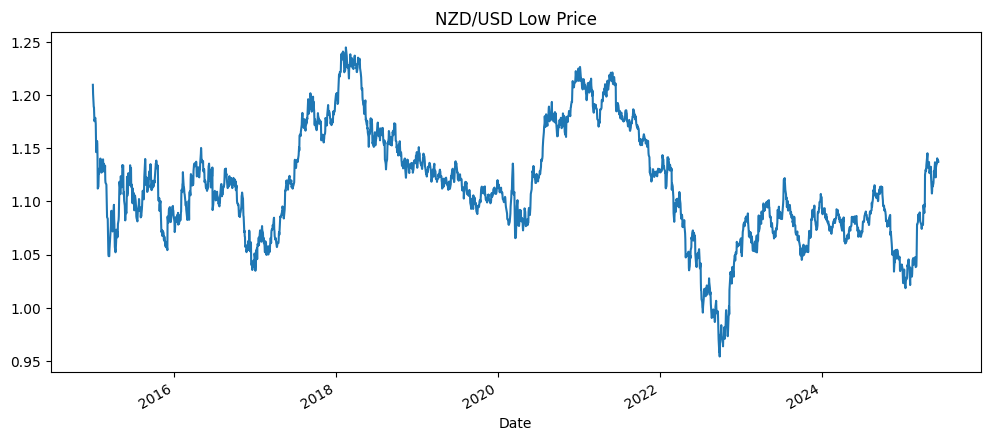

In [28]:
data['Low'].plot(figsize=(12, 5), title='NZD/USD Low Price')

## Boxplot

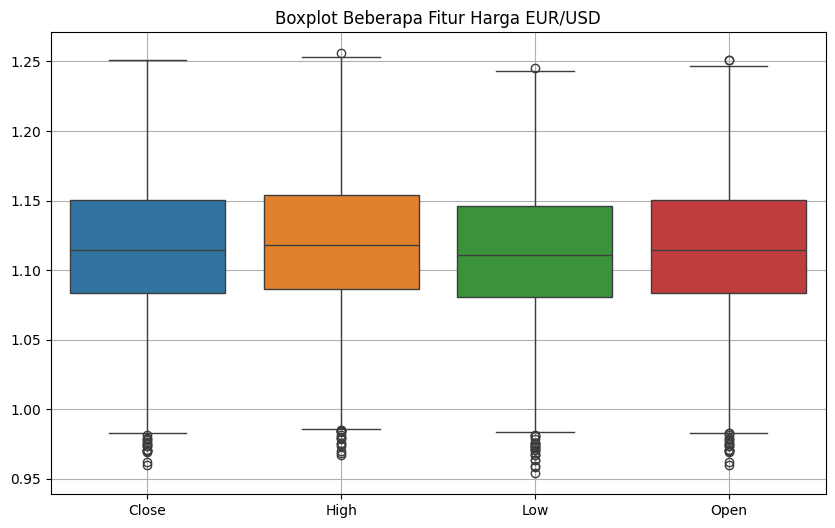

In [29]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[['Close', 'High', 'Low', 'Open']])
plt.title("Boxplot Beberapa Fitur Harga EUR/USD")
plt.grid(True)
plt.show()

### Insight :
- Distribusi merata dan bersih

# Data Reprocessing

In [30]:
data['Target'] = (data['Close'].shift(-1) > data['Close']).astype(int)
data['High_prev1'] = data['High'].shift(1)
data['Low_prev1'] = data['Low'].shift(1)
data['Close_prev1'] = data['Close'].shift(1)
data['Close_prev2'] = data['Close'].shift(2)
data['TrendYesterday'] = (data['Close_prev1'] > data['Close_prev2']).astype(int)

def add_technical_indicators(data):
    data = data.sort_index()

    # Moving Averages
    data['SMA_10'] = ta.trend.sma_indicator(data['Close'], window=10)
    data['SMA_20'] = ta.trend.sma_indicator(data['Close'], window=20)
    data['SMA_50'] = ta.trend.sma_indicator(data['Close'], window=50)
    data['EMA_10'] = ta.trend.ema_indicator(data['Close'], window=10)
    data['EMA_20'] = ta.trend.ema_indicator(data['Close'], window=20)
    data['EMA_50'] = ta.trend.ema_indicator(data['Close'], window=50)

    # Momentum Indicators
    data['RSI_14'] = ta.momentum.rsi(data['Close'], window=14)
    data['MACD'] = ta.trend.macd(data['Close'])
    data['MACD_signal'] = ta.trend.macd_signal(data['Close'])
    data['Stochastic_k'] = ta.momentum.stoch(data['High'], data['Low'], data['Close'], window=14)
    data['Stochastic_d'] = ta.momentum.stoch_signal(data['High'], data['Low'], data['Close'], window=14)
    data['CCI'] = ta.trend.cci(data['High'], data['Low'], data['Close'], window=20)

    # Volatility Indicators
    data['ATR_14'] = ta.volatility.average_true_range(data['High'], data['Low'], data['Close'], window=14)
    data['Bollinger_High'] = ta.volatility.bollinger_hband(data['Close'], window=20)
    data['Bollinger_Low'] = ta.volatility.bollinger_lband(data['Close'], window=20)
    data['Bollinger_Mid'] = ta.volatility.bollinger_mavg(data['Close'], window=20)
    data['StdDev_20'] = data['Close'].rolling(window=20).std()

    # Price Action
    data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1))
    data['ROC_5'] = data['Close'].pct_change(5)

    # Candlestick patterns (simple)
    data['Body'] = abs(data['Close'] - data['Open'])
    data['Upper_Shadow'] = data['High'] - data[['Close', 'Open']].max(axis=1)
    data['Lower_Shadow'] = data[['Close', 'Open']].min(axis=1) - data['Low']
    data['Bullish_Engulfing'] = ((data['Close'] > data['Open'].shift(1)) & (data['Open'] < data['Close'].shift(1))).astype(int)

    # Fill NA hasil rolling dan indicator
    data.fillna(method='bfill', inplace=True)
    data.fillna(method='ffill', inplace=True)

    return data

data = add_technical_indicators(data)

def dynamic_fibo_levels(row):
    if pd.isna(row['High_prev1']) or pd.isna(row['Low_prev1']) or pd.isna(row['TrendYesterday']):
        return None
    high = row['High_prev1']
    low = row['Low_prev1']
    trend = row['TrendYesterday']
    start, end = (low, high) if trend == 1 else (high, low)
    levels = {
        0: start,
        23.6: start + 0.236 * (end - start),
        38.2: start + 0.382 * (end - start),
        50.0: start + 0.5 * (end - start),
        61.8: start + 0.618 * (end - start),
        100: end
    }
    return levels

data['FiboLevels'] = data.apply(dynamic_fibo_levels, axis=1)

def fibo_distance_features(row):
    if pd.isna(row['Close']) or row['FiboLevels'] is None:
        return pd.Series([np.nan]*6)
    close = row['Close']
    levels = row['FiboLevels']
    return pd.Series([abs(close - levels[lvl]) for lvl in [0, 23.6, 38.2, 50.0, 61.8, 100]])

dist_cols = ['FiboDist_0', 'FiboDist_23.6', 'FiboDist_38.2', 'FiboDist_50', 'FiboDist_61.8', 'FiboDist_100']
data[dist_cols] = data.apply(fibo_distance_features, axis=1)

data['Close_T1'] = data['Close'].shift(-1)
def nearest_fibo_label(row):
    if pd.isna(row['Close_T1']) or row['FiboLevels'] is None:
        return np.nan
    levels = row['FiboLevels']
    dist_to_levels = {lvl: abs(row['Close_T1'] - val) for lvl, val in levels.items()}
    return min(dist_to_levels, key=dist_to_levels.get)

data['FiboLabel'] = data.apply(nearest_fibo_label, axis=1)

# Drop rows with NaN in required columns
data.dropna(subset=dist_cols + ['FiboLabel', 'Target'], inplace=True)

# Encode FiboLabel (categorical)
le_fibo = LabelEncoder()
data['FiboLabelEncoded'] = le_fibo.fit_transform(data['FiboLabel'])

<ipython-input-30-3657379056>:45: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)
<ipython-input-30-3657379056>:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


Menambahkan indikator teknikal seperti EMA, SMA, RSI, MACD, Stochastic, CCI, ATR, Bollinger, Fibbonacci Retracement, dan beberapa sinyal naik turun.

# Modelling

In [31]:
# ===== Daftar fitur =====
features_price = ['Close', 'High', 'Low', 'Open']
features_fibo = ['FiboDist_0', 'FiboDist_23.6', 'FiboDist_38.2', 'FiboDist_50', 'FiboDist_61.8', 'FiboDist_100']
features_tech = [
    'SMA_10', 'SMA_20', 'SMA_50',
    'EMA_10', 'EMA_20', 'EMA_50',
    'RSI_14', 'MACD', 'MACD_signal',
    'Stochastic_k', 'Stochastic_d', 'CCI',
    'ATR_14', 'Bollinger_High', 'Bollinger_Low', 'Bollinger_Mid', 'StdDev_20',
    'Log_Return', 'ROC_5',
    'Body', 'Upper_Shadow', 'Lower_Shadow', 'Bullish_Engulfing'
]

# Pastikan data sudah lengkap, tanpa NaN di semua kolom yang ingin dipakai
all_features = features_price + features_fibo + features_tech
data = data.dropna(subset=all_features + ['Target', 'FiboLabelEncoded'])

# ===== Scaling fitur =====
scaler_price = MinMaxScaler()
scaled_price = scaler_price.fit_transform(data[features_price])

scaler_fibo = MinMaxScaler()
scaled_fibo = scaler_fibo.fit_transform(data[features_fibo])

scaler_tech = MinMaxScaler()
scaled_tech = scaler_tech.fit_transform(data[features_tech])

# Gabungkan semua fitur menjadi 1 array input model
features_combined = np.hstack([scaled_price, scaled_fibo, scaled_tech])

# Misal target klasifikasi & regresi sama seperti sebelumnya
y_cls = data['Target'].values
y_fibo = data['FiboLabelEncoded'].values

# Misal regresi hanya prediksi harga Close, High, Low (scaled)
y_reg = scaled_price[:, :3]

# ===== Sequence creation function sama seperti sebelumnya =====
def create_sequences(data_features, y_reg, y_cls, y_fibo, window_size):
    X, y_reg_seq, y_cls_seq, y_fibo_seq = [], [], [], []
    for i in range(len(data_features) - window_size):
        X.append(data_features[i:i+window_size])
        y_reg_seq.append(y_reg[i+window_size])
        y_cls_seq.append(y_cls[i+window_size])
        y_fibo_seq.append(y_fibo[i+window_size])
    return np.array(X), np.array(y_reg_seq), np.array(y_cls_seq), np.array(y_fibo_seq)

# ===== Train-test split =====
split_idx = int(len(data) * 0.8)

features_train = features_combined[:split_idx]
features_test = features_combined[split_idx:]

y_reg_train = y_reg[:split_idx]
y_reg_test = y_reg[split_idx:]

y_cls_train = y_cls[:split_idx]
y_cls_test = y_cls[split_idx:]

y_fibo_train = y_fibo[:split_idx]
y_fibo_test = y_fibo[split_idx:]

window_size_reg = 270
window_size_cls = 280

# Create sequences for regression task
X_reg_train, y_reg_seq_train, _, _ = create_sequences(features_train, y_reg_train, y_cls_train, y_fibo_train, window_size_reg)
X_reg_test, y_reg_seq_test, _, _ = create_sequences(features_test, y_reg_test, y_cls_test, y_fibo_test, window_size_reg)

# Create sequences for classification task (multi-task)
X_cls_train, _, y_cls_seq_train, y_fibo_seq_train = create_sequences(features_train, y_reg_train, y_cls_train, y_fibo_train, window_size_cls)
X_cls_test, _, y_cls_seq_test, y_fibo_seq_test = create_sequences(features_test, y_reg_test, y_cls_test, y_fibo_test, window_size_cls)

print(f"Train regression samples: {len(X_reg_train)}, Test regression samples: {len(X_reg_test)}")
print(f"Train classification samples: {len(X_cls_train)}, Test classification samples: {len(X_cls_test)}")

input_reg = Input(shape=(window_size_reg, X_reg_train.shape[2]))
x_reg = LSTM(64)(input_reg)
out_reg = Dense(3)(x_reg)
model_reg = Model(inputs=input_reg, outputs=out_reg)
# Use the explicit Keras loss object instead of the string alias
model_reg.compile(optimizer=Adam(0.001), loss=tf.keras.losses.MeanSquaredError())

checkpoint_reg = ModelCheckpoint('model_reg_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
earlystop_reg = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

history = model_reg.fit(
    X_reg_train, y_reg_seq_train,
    validation_data=(X_reg_test, y_reg_seq_test),
    epochs=50, batch_size=16,
    callbacks=[checkpoint_reg, earlystop_reg],
    verbose=1
)

Train regression samples: 1903, Test regression samples: 274
Train classification samples: 1893, Test classification samples: 264
Epoch 1/50
118/119 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0568
Epoch 1: val_loss improved from inf to 0.00167, saving model to model_reg_best.h5


119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0561 - val_loss: 0.0017
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0012
Epoch 2: val_loss improved from 0.00167 to 0.00113, saving model to model_reg_best.h5


119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 8.9958e-04
Epoch 3: val_loss improved from 0.00113 to 0.00092, saving model to model_reg_best.h5


119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 8.9867e-04 - val_loss: 9.1601e-04
Epoch 4/50
118/119 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.8705e-04
Epoch 4: val_loss improved from 0.00092 to 0.00061, saving model to model_reg_best.h5


119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 5.8712e-04 - val_loss: 6.0840e-04
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.0010e-04
Epoch 5: val_loss did not improve from 0.00061
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 4.9997e-04 - val_loss: 6.8819e-04
Epoch 6/50
114/119 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4740e-04
Epoch 6: val_loss improved from 0.00061 to 0.00050, saving model to model_reg_best.h5


119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.4493e-04 - val_loss: 4.9920e-04
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.7691e-04
Epoch 7: val_loss improved from 0.00050 to 0.00040, saving model to model_reg_best.h5


119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 3.7678e-04 - val_loss: 4.0127e-04
Epoch 8/50
116/119 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.4090e-04
Epoch 8: val_loss improved from 0.00040 to 0.00033, saving model to model_reg_best.h5


119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.4115e-04 - val_loss: 3.3373e-04
Epoch 9/50
115/119 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.2898e-04
Epoch 9: val_loss did not improve from 0.00033
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 3.2849e-04 - val_loss: 3.5342e-04
Epoch 10/50
116/119 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.0301e-04
Epoch 10: val_loss improved from 0.00033 to 0.00030, saving model to model_reg_best.h5


119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.0294e-04 - val_loss: 3.0457e-04
Epoch 11/50
116/119 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.6948e-04
Epoch 11: val_loss improved from 0.00030 to 0.00029, saving model to model_reg_best.h5


119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6964e-04 - val_loss: 2.8570e-04
Epoch 12/50
117/119 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.7530e-04
Epoch 12: val_loss did not improve from 0.00029
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.7523e-04 - val_loss: 3.2989e-04
Epoch 13/50
114/119 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.7686e-04
Epoch 13: val_loss did not improve from 0.00029
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2.7744e-04 - val_loss: 3.1871e-04
Epoch 14/50
118/119 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8657e-04
Epoch 14: val_loss did not improve from 0.00029
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.8650e-04 - val_loss: 3.1993e-04
Epoch 15/50
118/119 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.4062e-04
Epoch 15: val_loss did not improve from 0.00029
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2.4086e-04 - val_loss: 3.4883e-04
Epoch 16/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.6047e-04
Epoch 16: val_loss improv

119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.6038e-04 - val_loss: 2.5606e-04
Epoch 17/50
118/119 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.4262e-04
Epoch 17: val_loss did not improve from 0.00026
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.4252e-04 - val_loss: 2.6447e-04
Epoch 18/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9496e-04
Epoch 18: val_loss did not improve from 0.00026
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.9477e-04 - val_loss: 2.7385e-04
Epoch 19/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.7308e-04
Epoch 19: val_loss improved from 0.00026 to 0.00023, saving model to model_reg_best.h5


119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.7283e-04 - val_loss: 2.2798e-04
Epoch 20/50
118/119 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.2770e-04
Epoch 20: val_loss did not improve from 0.00023
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.2793e-04 - val_loss: 2.5055e-04
Epoch 21/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.5738e-04
Epoch 21: val_loss did not improve from 0.00023
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.5737e-04 - val_loss: 2.3226e-04
Epoch 22/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.6266e-04
Epoch 22: val_loss did not improve from 0.00023
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.6275e-04 - val_loss: 2.8164e-04
Epoch 23/50
118/119 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.6489e-04
Epoch 23: val_loss did not improve from 0.00023
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.6481e-04 - val_loss: 4.1655e-04
Epoch 24/50
114/119 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.4975e-04
Epoch 24: val_loss impr

119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.4993e-04 - val_loss: 2.0625e-04
Epoch 25/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.3521e-04
Epoch 25: val_loss did not improve from 0.00021
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.3532e-04 - val_loss: 2.4232e-04
Epoch 26/50
115/119 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.3174e-04
Epoch 26: val_loss did not improve from 0.00021
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.3236e-04 - val_loss: 2.9035e-04
Epoch 27/50
118/119 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.7940e-04
Epoch 27: val_loss did not improve from 0.00021
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.7896e-04 - val_loss: 2.2387e-04
Epoch 28/50
118/119 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.3847e-04
Epoch 28: val_loss did not improve from 0.00021
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.3870e-04 - val_loss: 2.3068e-04
Epoch 29/50
114/119 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.8008e-04
Epoch 29: val_loss did 

# Evaluasi


In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ===== Evaluasi Model Regresi =====
# Prediksi
y_pred_scaled = model_reg.predict(X_reg_test)

# Inverse scaling hasil prediksi dan target
y_pred_unscaled = scaler_price.inverse_transform(
    np.hstack([y_pred_scaled, np.zeros((y_pred_scaled.shape[0], 1))])
)[:, :3]

y_true_unscaled = scaler_price.inverse_transform(
    np.hstack([y_reg_seq_test, np.zeros((y_reg_seq_test.shape[0], 1))])
)[:, :3]

# Nama kolom target
target_names = ['Close', 'High', 'Low']

# Evaluasi tiap target
for i, name in enumerate(target_names):
    mse = mean_squared_error(y_true_unscaled[:, i], y_pred_unscaled[:, i])
    mae = mean_absolute_error(y_true_unscaled[:, i], y_pred_unscaled[:, i])
    rmse = np.sqrt(mse)

    print(f"=== {name} ===")
    print(f"MSE:  {mse:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE:  {mae:.6f}")
    print()


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
=== Close ===
MSE:  0.000011
RMSE: 0.003373
MAE:  0.002426

=== High ===
MSE:  0.000023
RMSE: 0.004798
MAE:  0.003531

=== Low ===
MSE:  0.000018
RMSE: 0.004206
MAE:  0.003098



## Visualisasi perbandingan harga asli dengan harga prediksi

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


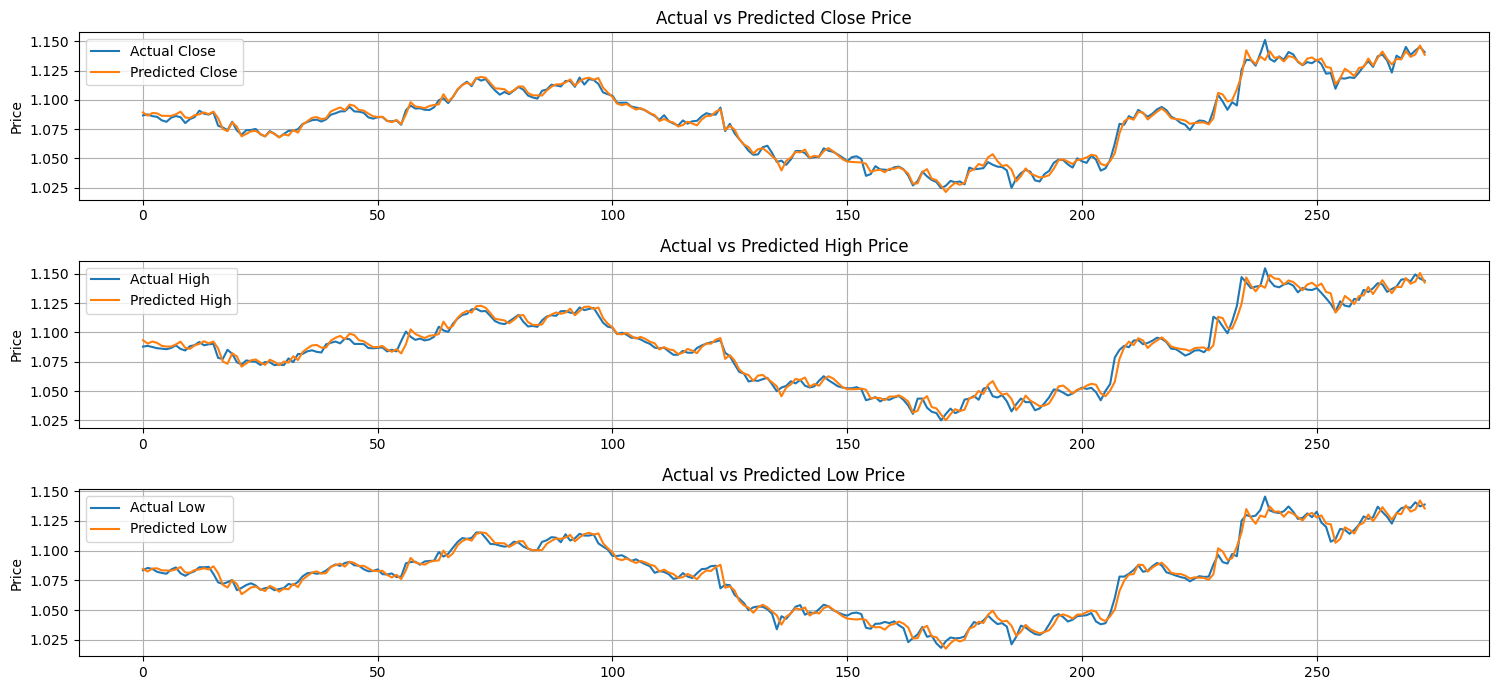

In [33]:

pred_reg = model_reg.predict(X_reg_test)

dummy_open_actual = np.zeros((y_reg_seq_test.shape[0], scaled_price.shape[1] - 3))
dummy_open_pred = np.zeros((pred_reg.shape[0], scaled_price.shape[1] - 3))

y_reg_seq_test_combined = np.hstack((y_reg_seq_test, dummy_open_actual))
pred_reg_combined = np.hstack((pred_reg, dummy_open_pred))


# Inverse transform
y_reg_inv = scaler_price.inverse_transform(y_reg_seq_test_combined)[:, :3]
pred_reg_inv = scaler_price.inverse_transform(pred_reg_combined)[:, :3]


# Plotting
plt.figure(figsize=(15, 7))

# Plot Close Price
plt.subplot(3, 1, 1)
plt.plot(y_reg_inv[:, 0], label='Actual Close')
plt.plot(pred_reg_inv[:, 0], label='Predicted Close')
plt.title('Actual vs Predicted Close Price')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Plot High Price
plt.subplot(3, 1, 2)
plt.plot(y_reg_inv[:, 1], label='Actual High')
plt.plot(pred_reg_inv[:, 1], label='Predicted High')
plt.title('Actual vs Predicted High Price')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Plot Low Price
plt.subplot(3, 1, 3)
plt.plot(y_reg_inv[:, 2], label='Actual Low')
plt.plot(pred_reg_inv[:, 2], label='Predicted Low')
plt.title('Actual vs Predicted Low Price')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Menyimpan Model dan Scaler

In [34]:
from joblib import dump

# Simpan model regresi
model_reg.save("regression_model.h5")

# Simpan scaler untuk price, fibo, dan technical features
dump(scaler_price, "scaler_price.save")
dump(scaler_fibo, "scaler_fibo.save")
dump(scaler_tech, "scaler_tech.save")

['scaler_tech.save']

## Baca model untuk melakukan prediksi hari ini

In [35]:

model_reg = load_model('model_reg_best.h5')

latest_data = get_eurusd_data(end_date=datetime.today().strftime('%Y-%m-%d'), force_download=True)

if len(latest_data) < window_size_reg + 1:
    print(f"Data tidak cukup untuk membuat sequence. Diperlukan minimal {window_size_reg + 1} baris data.")
else:
    latest_data['Target'] = (latest_data['Close'].shift(-1) > latest_data['Close']).astype(int) # Target is not strictly needed for prediction, but added for consistency
    latest_data['High_prev1'] = latest_data['High'].shift(1)
    latest_data['Low_prev1'] = latest_data['Low'].shift(1)
    latest_data['Close_prev1'] = latest_data['Close'].shift(1)
    latest_data['Close_prev2'] = latest_data['Close'].shift(2)
    latest_data['TrendYesterday'] = (latest_data['Close_prev1'] > latest_data['Close_prev2']).astype(int)

    latest_data = add_technical_indicators(latest_data)

    latest_data['FiboLevels'] = latest_data.apply(dynamic_fibo_levels, axis=1)
    latest_data[dist_cols] = latest_data.apply(fibo_distance_features, axis=1)
    required_cols_for_prediction = all_features # These are the columns used to train the model
    latest_data_prepared = latest_data[required_cols_for_prediction].dropna()


    if len(latest_data_prepared) < window_size_reg:
         print(f"Data terbaru setelah preprocessing dan dropna tidak cukup untuk membuat sequence. Diperlukan minimal {window_size_reg} baris data non-NaN.")
    else:
        input_data_for_prediction = latest_data_prepared[-window_size_reg:]

        scaled_price_pred = scaler_price.transform(input_data_for_prediction[features_price])
        scaled_fibo_pred = scaler_fibo.transform(input_data_for_prediction[features_fibo])
        scaled_tech_pred = scaler_tech.transform(input_data_for_prediction[features_tech])

        features_combined_pred = np.hstack([scaled_price_pred, scaled_fibo_pred, scaled_tech_pred])
        X_pred = np.array([features_combined_pred])

        predicted_scaled_prices = model_reg.predict(X_pred)
        dummy_array = np.zeros((predicted_scaled_prices.shape[0], len(features_price))) # Shape (1, 4)
        dummy_array[:, :3] = predicted_scaled_prices # Put the predicted Close, High, Low

        predicted_original_prices = scaler_price.inverse_transform(dummy_array)[0]

        predicted_close = predicted_original_prices[0]
        predicted_high = predicted_original_prices[1]
        predicted_low = predicted_original_prices[2]

Mengunduh data EUR/USD dari Yahoo Finance: 2015-01-01 sampai 2025-06-11


[*********************100%***********************]  1 of 1 completed
<ipython-input-30-3657379056>:45: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)
<ipython-input-30-3657379056>:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


Data disimpan ke eurusd_data.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


In [36]:
        print("\nHasil Prediksi untuk Hari Ini:")
        print(f"Prediksi Harga Close: {predicted_close:.5f}")
        print(f"Prediksi Harga High:  {predicted_high:.5f}")
        print(f"Prediksi Harga Low:   {predicted_low:.5f}")

        json_data = {
            'predicted_close': predicted_close,
            'predicted_high': predicted_high,
            'predicted_low': predicted_low
        }
        with open('prediction_results.json', 'w') as json_file:
            json.dump(json_data, json_file)


Hasil Prediksi untuk Hari Ini:
Prediksi Harga Close: 1.13886
Prediksi Harga High:  1.14218
Prediksi Harga Low:   1.13513
